In [11]:
### read train and test dataste

import pandas as pd

train_path = 'Train_Dataset.csv'
test_path = 'Test_Dataset.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [12]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [4]:
## prepare data for creating bert embeddings

# import tensorflow as tf
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
# from bert import tokenization

from bert import tokenization
import random

BertTokenizer = bert.tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)


vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

def dataset_embedding(dataset_path, tokenizer, batch_size=32):

    dataset = pd.read_csv(dataset_path)[["tweet", "sarcastic"]]
    dataset = dataset[dataset['tweet'].notna()]
    
    tokenized_tweets = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweet)) for tweet in dataset['tweet']]
    
    tweets_with_len = [[tweet, dataset['sarcastic'].iloc[i], len(tweet)] for i, tweet in enumerate(tokenized_tweets)]
    random.Random(42).shuffle(tweets_with_len)
    
    tweets_with_len.sort(key=lambda x: x[2])
    sorted_tweets_labels = [(tweet_lab[0], tweet_lab[1]) for tweet_lab in tweets_with_len] # remove tweet len
    processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_tweets_labels, output_types=(tf.int32, tf.int32))
    
    return processed_dataset.padded_batch(batch_size, padded_shapes=((None, ), ()))

train_data = dataset_embedding(train_path, tokenizer)
test_data = dataset_embedding(test_path, tokenizer)



























2023-01-10 13:36:22.223882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 13:36:22.224127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 13:36:22.234268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 13:36:22.240974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-10 13:36:22.242432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [8]:
## create lstm model for tweet classification

import tensorflow as tf


lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.vocab), 32),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),

    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),
    tf.keras.layers.LSTM(32),

    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', f1_m])

print(lstm.summary())



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          976704    
                                                                 
 lstm_3 (LSTM)               (None, None, 32)          8320      
                                                                 
 time_distributed_2 (TimeDis  (None, None, 32)         1056      
 tributed)                                                       
                                                                 
 lstm_4 (LSTM)               (None, None, 32)          8320      
                                                                 
 time_distributed_3 (TimeDis  (None, None, 32)         1056      
 tributed)                                                       
                                                                 
 lstm_5 (LSTM)               (None, 32)               

In [10]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']

In [12]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

RuntimeError: Physical devices cannot be modified after being initialized

In [14]:
with tf.device('/cpu:0'):
    lstm.fit(train_data, epochs=10, validation_data=test_data, class_weight={1: 4, 0: 1})

Epoch 1/10
217/217 [==============================] - 5s 18ms/step - loss: 1.0947 - accuracy: 0.5847 - f1_m: 0.4171 - val_loss: 0.8641 - val_accuracy: 0.3179 - val_f1_m: 0.2224
Epoch 2/10
217/217 [==============================] - 3s 15ms/step - loss: 0.6338 - accuracy: 0.7508 - f1_m: 0.7167 - val_loss: 0.9795 - val_accuracy: 0.5971 - val_f1_m: 0.2629
Epoch 3/10
217/217 [==============================] - 3s 15ms/step - loss: 0.3936 - accuracy: 0.9041 - f1_m: 0.8288 - val_loss: 0.6026 - val_accuracy: 0.7521 - val_f1_m: 0.2201
Epoch 4/10
217/217 [==============================] - 3s 15ms/step - loss: 0.2460 - accuracy: 0.9508 - f1_m: 0.8890 - val_loss: 1.4440 - val_accuracy: 0.5171 - val_f1_m: 0.2441
Epoch 5/10
217/217 [==============================] - 3s 15ms/step - loss: 0.1639 - accuracy: 0.9518 - f1_m: 0.9102 - val_loss: 0.8573 - val_accuracy: 0.6886 - val_f1_m: 0.2491
Epoch 6/10
217/217 [==============================] - 3s 15ms/step - loss: 0.0905 - accuracy: 0.9784 - f1_m: 0.9538

In [5]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [6]:
import os
import re

import numpy as np
import tensorflow as tf

np.random.seed(1)
# tf.set_random_seed(2)
tf.random.set_seed(2)

import pandas as pd
import keras
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import contractions

In [7]:

import pandas as pd

train_path = 'Train_Dataset.csv'
test_path = 'Test_Dataset.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

data=pd.concat([train,test],axis=0)
train, test = train_test_split(data, random_state = 42, test_size=0.1)
print(train.shape)
print(test.shape)

(7500, 2)
(834, 2)


In [8]:


def clean_text(text, mapping):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")
    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")
    
    # Random note: removing the URL's slightly degraded performance, it's possible the model learned that certain URLs were positive/negative
    # And was able to extrapolate that to retweets. Could also explain why re-training the Embeddings improves performance.
    # remove twitter url's
    text = re.sub(r"http[s]?://t.co/[A-Za-z0-9]*","TWITTERURL",text)
    mapped_string = []
    for t in text.split(" "):

        mapped_string.append(contractions.fix(t))  
    return ' '.join(mapped_string)

In [9]:
#training constants
MAX_SEQ_LEN = 36 #this is based on a quick analysis of the len of sequences train['text'].apply(lambda x : len(x.split(' '))).quantile(0.95)
DEFAULT_BATCH_SIZE = 16

In [11]:
# Get tweets from Data frame and convert to list of "texts" scrubbing based on clean_text function
# CONTRACTION_MAPPING is a map of common contractions(e.g don't => do not)
train_text_vec = [clean_text(text, contractions.fix) for text in train['tweet'].values]
test_text_vec = [clean_text(text, contractions.fix) for text in test['tweet'].values]


# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_text_vec)
train_text_vec = tokenizer.texts_to_sequences(train_text_vec)
test_text_vec = tokenizer.texts_to_sequences(test_text_vec)

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN)

print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", train_text_vec.max(), "\n")

print('Sample Tweet Before Processing:', train["tweet"].values[0])
print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[0]]), '\n')

print('What the model will interpret:', train_text_vec[0].tolist())

Number of Tokens: 14570
Max Token Index: 14570 

Sample Tweet Before Processing: The Vernon in town, best pub going. No questions asked.
Sample Tweet After Processing: ['The Vernon in town best pub going No questions asked'] 

What the model will interpret: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 54, 9508, 9, 1126, 129, 763, 60, 251, 1035, 529]


In [12]:
# One Hot Encode Y values:
encoder = LabelEncoder()
y_train = encoder.fit_transform(train['sarcastic'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(test['sarcastic'].values)
y_test = to_categorical(y_test) 

In [13]:
# get an idea of the distribution of the text values
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
ctr = Counter(train['sarcastic'].values)
print('Distribution of Classes:', ctr)

# get class weights for the training data, this will be used data
y_train_int = np.argmax(y_train,axis=1)
# cws = class_weight.compute_class_weight('balanced', np.unique(y_train_int), y_train_int)
cws=class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train_int), y= y_train_int)
print(cws)

Distribution of Classes: Counter({0: 5745, 1: 1755})
[0.65274151 2.13675214]


### BASELINE Performance

In [23]:
# 
print('Dominant Class: ', ctr.most_common(n = 1)[0][0])
print('Baseline Accuracy Dominant Class', (ctr.most_common(n = 1)[0][0] == test['sarcastic'].values).mean())

preds = np.zeros_like(y_test)
preds[:, 0] = 1
preds[0] = 1 #done to suppress warning from numpy for f1 score
print('F1 Score:', f1_score(y_test, preds, average='weighted'))

Dominant Class:  0
Baseline Accuracy Dominant Class 0.7853717026378897
F1 Score: 0.6909583146109036


Baseline Accuracy Using Naive Bayes:  0.7937649880095923
F1 Score: 0.7103767684559419


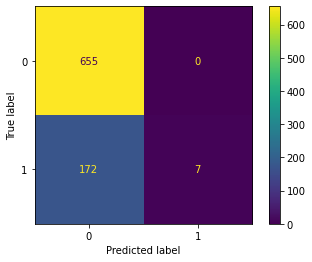

In [24]:
# Naive Bayse Baseline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using Naive Bayes: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

cm = confusion_matrix(y_test.argmax(axis = 1), predictions, labels=encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=encoder.classes_)
disp.plot()

plt.show()









# _ = plot_confusion_matrix(y_test.argmax(axis = 1), y_true=predictions,labels=encoder.classes_, normalize=True)


Baseline Accuracy Using RFC:  0.8237410071942446
F1 Score: 0.7762590404150771


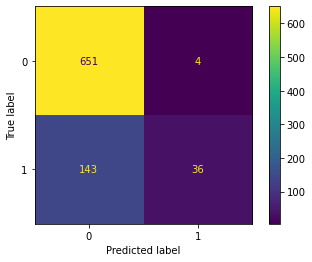

In [25]:

# Random Forest Baseline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=100)), #100 estimators will be the new default in version 0.22
])
text_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using RFC: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

cm = confusion_matrix(y_test.argmax(axis = 1), predictions, labels=encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=encoder.classes_)
disp.plot()

plt.show()


In [30]:
def threshold_search(y_true, y_proba, average = None):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold, average=average)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result


def train(model, 
          X_train, y_train, X_test, y_test, 
          checkpoint_path=r'model.{epoch:02d}-{val_loss:.2f}.h5', 
          epcohs = 25, 
          batch_size = DEFAULT_BATCH_SIZE, 
          class_weights = None, 
          fit_verbose=2,
          print_summary = True
         ):
    m = model()
    if print_summary:
        print(m.summary())
    with tf.device('/cpu:0'):
        m.fit(
            X_train, 
            y_train, 
            #this is bad practice using test data for validation, in a real case would use a seperate validation set
            validation_data=(X_test, y_test),  
            epochs=epcohs, 
            batch_size=batch_size,
            # class_weight=class_weights,
             #saves the most accurate model, usually you would save the one with the lowest loss
            callbacks= [
                ModelCheckpoint(filepath=checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True),
                EarlyStopping(patience = 2)
            ],
            verbose=fit_verbose
        ) 
    print("\n\n****************************\n\n")
    print('Loading Best Model...')
    # m.load_weights(checkpoint_path)
    with tf.device('/cpu:0'):
        predictions = m.predict(X_test, verbose=1)
    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
    # cm = confusion_matrix(y_test.argmax(axis = 1), predictions, labels=encoder.classes_)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    #                             display_labels=encoder.classes_)
    # disp.plot()

    # plt.show()
    return m #returns best performing model

### deep learning architectures


In [31]:
def model_1():
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

m1 = train(model_1, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           class_weights=cws
          )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 36, 128)           1865088   
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 2)                 130       
                                                                 
Total params: 2,005,058
Trainable params: 2,005,058
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25


469/469 - 8s - loss: 0.5082 - accuracy: 0.7741 - val_loss: 0.3874 - val_accuracy: 0.8321 - 8s/epoch - 17ms/step
Epoch 2/25


469/469 - 7s - loss: 0.1921 - accuracy: 0.9280 - val_loss: 0.2509 - val_accuracy: 0.9017 - 7s/epoch - 15ms/step
Epoch 3/25


469/469 - 7s - loss: 0.0520 - accuracy: 0.9824 - val_loss: 0.4157 - val_accuracy: 0.8933 - 7s/epoch - 15ms/step
Epoch 4/25


469/469 - 7s - loss: 0.0271 - accuracy: 0.9913 - val_loss: 0.3536 - val_accuracy: 0.8993 - 7s/epoch - 15ms/step


****************************


Loading Best Model...
27/27 [==============================] - 0s 7ms/step
Validation Loss: 0.353633460796948
Test Accuracy 0.8992805755395683
F1 Score: 0.8998789642189035


In [32]:
def model_1b():
    """
    Using a Bidiretional LSTM. 
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25)))
    model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

_ = train(model_1b, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1b.h5',
           class_weights=cws,
           print_summary = True
          )

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 36, 128)           1865088   
                                                                 
 spatial_dropout1d (SpatialD  (None, 36, 128)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 dense_15 (Dense)            (None, 2)                 130       
                                                                 
Total params: 2,144,834
Trainable params: 2,144,834
No

469/469 - 34s - loss: 0.5256 - accuracy: 0.7672 - val_loss: 0.4306 - val_accuracy: 0.8106 - 34s/epoch - 72ms/step
Epoch 2/25


469/469 - 32s - loss: 0.2692 - accuracy: 0.8944 - val_loss: 0.2973 - val_accuracy: 0.8837 - 32s/epoch - 67ms/step
Epoch 3/25


469/469 - 32s - loss: 0.0950 - accuracy: 0.9655 - val_loss: 0.2774 - val_accuracy: 0.8993 - 32s/epoch - 68ms/step
Epoch 4/25


469/469 - 32s - loss: 0.0458 - accuracy: 0.9843 - val_loss: 0.3013 - val_accuracy: 0.9005 - 32s/epoch - 68ms/step
Epoch 5/25


469/469 - 32s - loss: 0.0296 - accuracy: 0.9892 - val_loss: 0.2898 - val_accuracy: 0.9149 - 32s/epoch - 68ms/step


****************************


Loading Best Model...
27/27 [==============================] - 1s 49ms/step
Validation Loss: 0.28980161668818033
Test Accuracy 0.9148681055155875
F1 Score: 0.9151241361333211


In [33]:
##  Convolution LSTM

def model_1c():
    """
    Adding dropout to reduce overfitting using a bidiretional LSTM
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
#     model.add(Flatten())
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
    return model


_ = train(model_1c, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1c.h5',
           class_weights=cws,
           print_summary = True
          )

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 36, 128)           1865088   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 36, 128)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 36, 256)          263168    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 33, 64)            65600     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                      

469/469 - 34s - loss: 0.5232 - accuracy: 0.7704 - val_loss: 0.4130 - val_accuracy: 0.8129 - 34s/epoch - 73ms/step
Epoch 2/25


469/469 - 32s - loss: 0.2670 - accuracy: 0.8940 - val_loss: 0.2930 - val_accuracy: 0.8789 - 32s/epoch - 69ms/step
Epoch 3/25


469/469 - 32s - loss: 0.0865 - accuracy: 0.9684 - val_loss: 0.2811 - val_accuracy: 0.9017 - 32s/epoch - 69ms/step
Epoch 4/25


469/469 - 32s - loss: 0.0418 - accuracy: 0.9872 - val_loss: 0.2907 - val_accuracy: 0.9113 - 32s/epoch - 69ms/step
Epoch 5/25


469/469 - 32s - loss: 0.0242 - accuracy: 0.9919 - val_loss: 0.3027 - val_accuracy: 0.9269 - 32s/epoch - 69ms/step


****************************


Loading Best Model...
27/27 [==============================] - 2s 50ms/step
Validation Loss: 0.3026573843094009
Test Accuracy 0.9268585131894485
F1 Score: 0.9260037355782942


### Only Convolution Netwrok

In [34]:
def model_1d():
    """
    Just for fun below is a model only using covolutions. This is pretty good and also trains very quickly(and predictions would also likely be fast) compared to the LSTM...
    It's equivalent to using an n-gram based approach.
    Usually in practice you would use a more complex architecture with multiple parallel convolutions that are combined before pooling(and usually both max and avg).
    Pure Convolutional NLP is definitely a solution worth exploring further.
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(64, 5))
    model.add(Conv1D(64, 3))
    model.add(Conv1D(64, 2))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


_ = train(model_1d, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           checkpoint_path='model_1d.h5',
           class_weights=cws,
           print_summary = True
          )

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 36, 128)           1865088   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 36, 128)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 64)            41024     
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 64)            12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 29, 64)            8256      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                     

469/469 - 2s - loss: 0.5266 - accuracy: 0.7679 - val_loss: 0.4231 - val_accuracy: 0.8082 - 2s/epoch - 4ms/step
Epoch 2/25


469/469 - 1s - loss: 0.2866 - accuracy: 0.8839 - val_loss: 0.3030 - val_accuracy: 0.8765 - 1s/epoch - 3ms/step
Epoch 3/25


469/469 - 1s - loss: 0.0872 - accuracy: 0.9709 - val_loss: 0.3418 - val_accuracy: 0.8813 - 1s/epoch - 3ms/step
Epoch 4/25


469/469 - 1s - loss: 0.0376 - accuracy: 0.9881 - val_loss: 0.3668 - val_accuracy: 0.9077 - 1s/epoch - 3ms/step


****************************


Loading Best Model...
27/27 [==============================] - 0s 2ms/step
Validation Loss: 0.3667692202934354
Test Accuracy 0.907673860911271
F1 Score: 0.9036209119418449


### Transfer learning with Glove embeddings

In [14]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def get_embdedings_matrix(embeddings_index, word_index, nb_words = None):
    all_embs = np.stack(embeddings_index.values())
    print('Shape of Full Embeddding Matrix', all_embs.shape)
    embed_dims = all_embs.shape[1]
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    #best to free up memory, given the size, which is usually ~3-4GB in memory
    del all_embs
    if nb_words is None:
        nb_words = len(word_index)
    else:
        nb_words = min(nb_words, len(word_index))
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_dims))
    found_vectors = 0
    words_not_found = []
    for word, i in tqdm(word_index.items()):
        if i >= nb_words: 
            continue
        embedding_vector = None
        if word in embeddings_index:
            embedding_vector = embeddings_index.get(word)
        elif word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get(word.lower())
        # for twitter check if the key is a hashtag
        elif '#'+word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get('#'+word.lower())
            
        if embedding_vector is not None: 
            found_vectors += 1
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append((word, i))

    print("% of Vectors found in Corpus", found_vectors / nb_words)
    return embedding_matrix, words_not_found

In [15]:
def load_glove(word_index):
#     print('Loading Glove')
    embed_file_path = 'glove.840B.300d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)

def load_twitter(word_index):
#     print('Loading Twitter')
    embed_file_path = 'glove.twitter.27B.200d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)

In [10]:
print('Loading Glove Model...')
glove_embed_matrix, words_not_found =  load_glove(tokenizer.word_index)

Loading Glove Model...


NameError: name 'load_glove' is not defined

In [16]:
print('Loading Twitter Model...')
twitter_embed_matrix, words_not_found =  load_twitter(tokenizer.word_index)

Loading Twitter Model...


/tmp/ipykernel_2729/2619492423.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))


0it [00:00, ?it/s]

Built Embedding Index: 1193514


/tmp/ipykernel_2729/58595443.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  twitter_embed_matrix, words_not_found =  load_twitter(tokenizer.word_index)


Shape of Full Embeddding Matrix (1193514, 200)


/tmp/ipykernel_2729/2181222872.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word, i in tqdm(word_index.items()):


  0%|          | 0/14570 [00:00<?, ?it/s]

% of Vectors found in Corpus 0.8024708304735758


In [31]:
from ipywidgets import IntProgress